# Exploring Trees and Shadows

We will analyze data from the NYC Tree Census and try to understand the interplay between tree health and shadows. A detailed description of the tree data can be found in StreetTreeCensus2015TreesDataDictionary20161102.pdf. It consists of a table that includes each tree in NYC, together with its location and other attributes (e.g., height, species, etc).
The shadow data was generated with the ShadowProfiler which calculates shadows cast by buildings in Manhattan. The program takes the dimension of buildings, and the light coming off of the sun, and calculates the shadow intensity and duration. See https://www.nytimes.com/interactive/2016/12/21/upshot/Mapping­the­Shadows­of­New­York­City.html

This notebook will help you get started with the analysis. Here, we use shapefiles (.shp)-- you can find more about shapefiles in https://en.wikipedia.org/wiki/Shapefile

We have constrained the data to Manhattan. So, just unzip this at 

    tar -xzf path/to/project/data.tar.gz
    
If you want to work with the full datasets:

Tree data--* https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35/data

Shapefiles--* https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nynta_17a.zip

Streets--* https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b/data


### Some tricks to make it easier to reload the modules while coding

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Loading base modules 

In [2]:
%reload_ext autoreload
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]

### Loading datasets

In [6]:
from functools import partial
import pyproj
from shapely.ops import transform

#these are the datasets we are working with
villages = gpd.GeoDataFrame.from_file('data/villages-mn.shp', driver='ESRI Shapefile')
streets = gpd.read_file('data/streets-mn.shp', driver='ESRI Shapefile')
trees = gpd.read_file('data/trees-mn.shp', driver='ESRI Shapefile')

### Converting coordinate reference system to UTM (flatten the maps to simplify spatial queries)

The Universal Transverse Mercator (UTM) coordinate reference system has its origin on the equator at a specific Longitude. Now the Y-values increase southwards and the X-values increase to the West. The UTM CRS is a global map projection. This means, it is generally used all over the world.(http://docs.qgis.org/2.0/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)

In [7]:
villages = villages.to_crs(epsg=26918)
streets = streets.to_crs(epsg=26918)
trees = trees.to_crs(epsg=26918)

In [8]:
len(villages)

29

In [9]:
villages

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685475,"POLYGON ((588876.1785597933 4519450.267877867,..."
1,1,Manhattan,061,MN17,Midtown-Midtown South,3.019206e+07,27035.738062,"POLYGON ((586678.6911153347 4513097.574779067,..."
2,1,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739787e+07,21638.781375,(POLYGON ((587703.2741437969 4510461.153370242...
3,1,Manhattan,061,MN20,Murray Hill-Kips Bay,1.446596e+07,23135.103743,(POLYGON ((587623.6256422841 4509648.642779417...
4,1,Manhattan,061,MN21,Gramercy,7.531311e+06,12092.422832,"POLYGON ((586251.3783624729 4510040.811386588,..."
5,1,Manhattan,061,MN27,Chinatown,1.450187e+07,20786.255196,"POLYGON ((585821.3946368636 4508335.179919497,..."
6,1,Manhattan,061,MN50,Stuyvesant Town-Cooper Village,5.573902e+06,11000.177313,(POLYGON ((587630.0675326242 4508660.108073168...
7,1,Manhattan,061,MN34,East Harlem North,2.449487e+07,30603.208700,(POLYGON ((590501.9336688609 4516815.013944671...
8,1,Manhattan,061,MN31,Lenox Hill-Roosevelt Island,2.150148e+07,37708.443102,(POLYGON ((589306.8937351991 4513658.171538641...
9,1,Manhattan,061,MN04,Hamilton Heights,1.609379e+07,17410.823138,"POLYGON ((589347.2057885575 4520476.782137589,..."


In [10]:
from datetime import datetime

m = trees.created_at

def get_date(x):
    dt = datetime.strptime(x, '%m/%d/%Y')
    return dt

trees['created_custom'] = trees.created_at.apply(lambda x: get_date(x))

In [11]:
t = trees.created_custom
print t.min(), t.max()

2015-05-19 00:00:00 2016-10-03 00:00:00


### Let's plot some trees and streets in Manhattan

To save time, you can work with smaller samples 

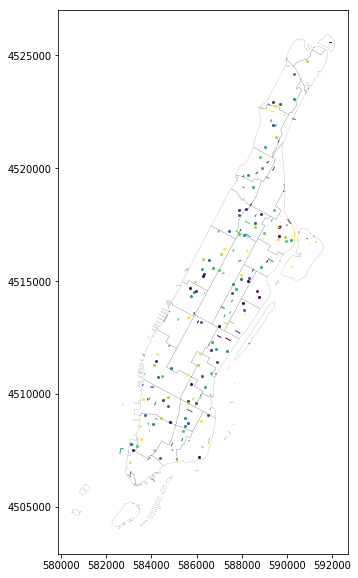

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
villages.sample(29).plot(ax=ax, color="white", linewidth=.1)
trees.sample(100).plot(ax=ax) # there are 6500 trees
streets.sample(100).plot(ax=ax)
#villages

### What are the contents and columns of these dataset?

In [11]:
trees.head()



,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,tree_id,trnk_light,trnk_other,trnk_wire,user_type,x_sp,y_sp,zip_city,zipcode,created_custom
0,8 COLUMBUS AVENUE,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,190422.0,No,No,No,Volunteer,988418.699656,219825.522669,New York,10023,2015-08-30
1,120 WEST 60 STREET,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,190426.0,No,No,No,Volunteer,988311.190028,219885.278455,New York,10023,2015-08-30
2,311 WEST 50 STREET,103940.0,1012700,1,Manhattan,No,No,No,104,3.0,...,208649.0,No,No,No,Volunteer,987769.116309,217157.856088,New York,10019,2015-09-07
3,170 EAST 75 STREET,107600.0,1012800,1,Manhattan,No,Yes,No,108,4.0,...,193310.0,No,Yes,No,Volunteer,995203.003673,220602.155302,New York,10021,2015-08-31
4,2163 BROADWAY,107038.0,1016300,1,Manhattan,No,No,No,107,6.0,...,199760.0,No,No,No,TreesCount Staff,989521.741413,224212.887582,New York,10024,2015-09-03


In [12]:
trees.columns

Index([       u'address',       u'block_id',        u'boro_ct',
             u'borocode',       u'boroname',     u'brnch_ligh',
           u'brnch_othe',     u'brnch_shoe',         u'cb_num',
             u'cncldist',     u'created_at',       u'curb_loc',
             u'geometry',         u'guards',         u'health',
             u'latitude',      u'longitude',            u'nta',
             u'nta_name',       u'problems',     u'root_grate',
           u'root_other',     u'root_stone',       u'sidewalk',
           u'spc_common',      u'spc_latin',       u'st_assem',
            u'st_senate',          u'state',         u'status',
              u'steward',     u'stump_diam',       u'tree_dbh',
              u'tree_id',     u'trnk_light',     u'trnk_other',
            u'trnk_wire',      u'user_type',           u'x_sp',
                 u'y_sp',       u'zip_city',        u'zipcode',
       u'created_custom'],
      dtype='object')

In [18]:
villages.columns

Index([  u'BoroCode',   u'BoroName', u'CountyFIPS',    u'NTACode',
          u'NTAName', u'Shape_Area', u'Shape_Leng',   u'geometry'],
      dtype='object')

In [14]:
villages.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,1,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685475,"POLYGON ((588876.1785597933 4519450.267877867,..."
1,1,Manhattan,061,MN17,Midtown-Midtown South,3.019206e+07,27035.738062,"POLYGON ((586678.6911153347 4513097.574779067,..."
2,1,Manhattan,061,MN19,Turtle Bay-East Midtown,1.739787e+07,21638.781375,(POLYGON ((587703.2741437969 4510461.153370242...
3,1,Manhattan,061,MN20,Murray Hill-Kips Bay,1.446596e+07,23135.103743,(POLYGON ((587623.6256422841 4509648.642779417...
4,1,Manhattan,061,MN21,Gramercy,7.531311e+06,12092.422832,"POLYGON ((586251.3783624729 4510040.811386588,..."


NTA Name=Neighbourhood Tabulation Area Code

### Now, let's find out where trees are located and save inside their metadata

Since this step takes a little while, we will also save this as a file

In [15]:
if 'village' not in trees.columns:
    def find(x):
        v = villages[villages.intersects(x)]['NTAName'].iloc[0]
        return v 
    trees['village'] = trees['geometry'].apply(lambda x: find(x))
    # let's save this to not run again in future
    trees.to_file('data/trees-mn.shp')

### Group trees by village and checking some basic statistics

In [16]:
trees_dead = trees.loc[trees['status']=="Dead"]
trees_dead.head()
len(trees_dead)

1802

In [17]:
groups = trees.groupby('village')
#groups.get_group('Upper West Side').describe()
groups.get_group('Marble Hill-Inwood').describe()

,block_id,cncldist,latitude,longitude,st_assem,st_senate,stump_diam,tree_dbh,tree_id,x_sp,y_sp
count,1419.000000,1419.0,1419.000000,1419.000000,1419.0,1419.0,1419.000000,1419.000000,1419.000000,1.419000e+03,1419.000000
mean,117378.390416,10.0,40.866748,-73.920800,72.0,31.0,0.162791,6.674419,73402.516561,1.006156e+06,255067.204889
std,53448.266974,0.0,0.003147,0.003615,0.0,0.0,1.580781,5.188110,56942.721095,9.994776e+02,1147.004765
min,111003.000000,10.0,40.859429,-73.928560,72.0,31.0,0.000000,0.000000,33733.000000,1.004009e+06,252400.008045
25%,111403.000000,10.0,40.864434,-73.923640,72.0,31.0,0.000000,3.000000,48477.500000,1.005371e+06,254224.017520
50%,111481.000000,10.0,40.866954,-73.920880,72.0,31.0,0.000000,5.000000,59348.000000,1.006133e+06,255141.093114
75%,111556.000000,10.0,40.868877,-73.918310,72.0,31.0,0.000000,9.000000,75222.500000,1.006845e+06,255842.286921
max,602589.000000,10.0,40.872890,-73.911202,72.0,31.0,36.000000,46.000000,451193.000000,1.008809e+06,257305.647840


### You can now explore the data and compile 'interesting' statistics about tree height, species, health, etc.

In [18]:
trees.head()

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,...,trnk_light,trnk_other,trnk_wire,user_type,village,x_sp,y_sp,zip_city,zipcode,created_custom
0,8 COLUMBUS AVENUE,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,No,No,No,Volunteer,Lincoln Square,988418.699656,219825.522669,New York,10023,2015-08-30
1,120 WEST 60 STREET,106099.0,1014500,1,Manhattan,No,No,No,107,3.0,...,No,No,No,Volunteer,Lincoln Square,988311.190028,219885.278455,New York,10023,2015-08-30
2,311 WEST 50 STREET,103940.0,1012700,1,Manhattan,No,No,No,104,3.0,...,No,No,No,Volunteer,Clinton,987769.116309,217157.856088,New York,10019,2015-09-07
3,170 EAST 75 STREET,107600.0,1012800,1,Manhattan,No,Yes,No,108,4.0,...,No,Yes,No,Volunteer,Upper East Side-Carnegie Hill,995203.003673,220602.155302,New York,10021,2015-08-31
4,2163 BROADWAY,107038.0,1016300,1,Manhattan,No,No,No,107,6.0,...,No,No,No,TreesCount Staff,Upper West Side,989521.741413,224212.887582,New York,10024,2015-09-03


## Now let's look at the shadows in different seasons

The csv files contain, for each season and each tree, the number of minutes the tree is under sunlight

In [19]:
shd = []
# summer
shd.append(pd.read_csv('data/tree-shade-june-21.csv'))
# fall and spring
shd.append(pd.read_csv('data/tree-shade-sep-22.csv'))
# winter
shd.append(pd.read_csv('data/tree-shade-dec-21.csv'))

In [19]:
shd

[        tree_id  time
 0        180683    78
 1        200540     0
 2        204026   318
 3        204337   169
 4        189565   145
 5        190422   539
 6        190426   429
 7        208649   484
 8        209610    26
 9        192755     3
 10       203719   236
 11       203726   155
 12       195202     0
 13       189465   365
 14       192998   310
 15       189834    48
 16       204208   338
 17       161339   352
 18       187311   192
 19       208201   402
 20       193093    39
 21       193310   533
 22       199760   525
 23       204325   109
 24       189700   162
 25       205044   145
 26       192942   171
 27       195265   308
 28       201555   392
 29       208407    47
 ...         ...   ...
 683758   183515   164
 683759   179860    88
 683760   178849   250
 683761   191692   192
 683762   180028   440
 683763   195286   268
 683764   170513   369
 683765   192369   297
 683766   198289    71
 683767   203987   217
 683768   190040   328
 683769   1

For each tree, compute the length of time in sun and shade for the different seasons

In [20]:
# season_shadow captures the time the tree is in shadow
# season_sun captures the time when the tree is not in shadow
tree_shd = {}

def extract_sun(season_shadow,season_sun,shade_max,shd):

    for i,r in shd.iterrows():

        id = r['tree_id']

        if id not in tree_shd:
            tree_shd[id] = {}

        tree_shd[id][season_shadow] = r['time']
        tree_shd[id][season_sun] = shade_max-r['time']

extract_sun('summer', 'summer_sun', 720, shd[0])
extract_sun('fall', 'fall_sun', 540, shd[1])
extract_sun('winter','winter_sun', 360, shd[2])

In [21]:
tree_shd[180683]

{'fall': 159,
 'fall_sun': 381,
 'summer': 78,
 'summer_sun': 642,
 'winter': 353,
 'winter_sun': 7}

### Can you find a correlation between the amount of sun and tree health?

### Is tree height associated with  health?  Do taller trees get more sun?

### Exploring tree species.

Here is the NYC list of trees you can use when you plant  a tree:
https://www.nycgovparks.org/trees/street-tree-planting/species-list

From that list, NYC says that only the following tolerate shade well (only 3!):

Tilia americana
Tilia tomentosa
Ulmus americana

How prevalent are these species? Are trees of these species healthier? Have they been planted in suitable places, where they get plenty of shade?

### Scratch code

In [22]:
# create an array with all trees, their health, and the time in shade and sun
tree_all_info = {}

for i,r in trees.iterrows():
    id = r['tree_id']
    if id not in tree_all_info:
            tree_all_info[id] = {}
            
    # copy tree fields
    tree_all_info[id]['tree_id'] = id    
    tree_all_info[id]['health'] = r['health']
    tree_all_info[id]['status'] = r['status']
    tree_all_info[id]['spc_common'] = r['spc_common']
    tree_all_info[id]['village'] = r['village']
    
    # make health numeric 
    if r['health']=="Good":
         tree_all_info[id]['health_num'] = 20
    if r['health']=="Poor":
         tree_all_info[id]['health_num'] = 5
    if r['health']=="Fair":
         tree_all_info[id]['health_num'] = 10
    if r['health']=="None":
         tree_all_info[id]['health_num'] = 0
            
    # copy shade/sun fields
    tree_all_info[id]['fall'] = tree_shd[id]['fall']
    tree_all_info[id]['fall_sun'] = tree_shd[id]['fall_sun']
    tree_all_info[id]['summer'] = tree_shd[id]['summer']
    tree_all_info[id]['summer_sun'] = tree_shd[id]['summer_sun']
    tree_all_info[id]['winter'] = tree_shd[id]['winter']
    tree_all_info[id]['winter_sun'] = tree_shd[id]['fall_sun']
    tree_all_info[id]['all_shade'] = 2*tree_shd[id]['fall'] + tree_shd[id]['summer'] + tree_shd[id]['winter']
    tree_all_info[id]['all_sun'] = 2*tree_shd[id]['fall_sun'] + tree_shd[id]['summer_sun'] + tree_shd[id]['winter_sun']



In [23]:
tree_all_info


{144029.0: {'all_shade': 1730,
  'all_sun': 430,
  'fall': 421,
  'fall_sun': 119,
  'health': u'Good',
  'health_num': 20,
  'spc_common': u'honeylocust',
  'status': u'Alive',
  'summer': 598,
  'summer_sun': 122,
  'tree_id': 144029.0,
  'village': u'SoHo-TriBeCa-Civic Center-Little Italy',
  'winter': 290,
  'winter_sun': 119},
 131078.0: {'all_shade': 1486,
  'all_sun': 674,
  'fall': 382,
  'fall_sun': 158,
  'health': u'Good',
  'health_num': 20,
  'spc_common': u'honeylocust',
  'status': u'Alive',
  'summer': 362,
  'summer_sun': 358,
  'tree_id': 131078.0,
  'village': u'Hudson Yards-Chelsea-Flatiron-Union Square',
  'winter': 360,
  'winter_sun': 158},
 131079.0: {'all_shade': 1436,
  'all_sun': 724,
  'fall': 319,
  'fall_sun': 221,
  'health': u'',
  'spc_common': u'',
  'status': u'Dead',
  'summer': 458,
  'summer_sun': 262,
  'tree_id': 131079.0,
  'village': u'Hudson Yards-Chelsea-Flatiron-Union Square',
  'winter': 340,
  'winter_sun': 221},
 131080.0: {'all_shade': 1

In [24]:
# find all tree species

import pandas as pd

# set rows as keys
species_df = pd.DataFrame.from_dict(tree_all_info,orient='index')



In [31]:
species_df

,status,summer,fall_sun,winter,all_sun,tree_id,summer_sun,winter_sun,health,spc_common,village,health_num,fall,all_shade
356.0,Alive,400,93,327,766,356.0,320,93,Poor,crab apple,Upper East Side-Carnegie Hill,5.0,447,1574
357.0,Alive,406,94,327,755,357.0,314,94,Good,Callery pear,Upper East Side-Carnegie Hill,20.0,446,1585
358.0,Alive,346,110,317,901,358.0,374,110,Good,Callery pear,Upper East Side-Carnegie Hill,20.0,430,1439
359.0,Alive,399,132,316,818,359.0,321,132,Good,Callery pear,Upper East Side-Carnegie Hill,20.0,408,1522
394.0,Alive,498,91,360,535,394.0,222,91,Fair,honeylocust,Upper East Side-Carnegie Hill,10.0,449,1805
395.0,Alive,474,87,360,579,395.0,246,87,Good,honeylocust,Upper East Side-Carnegie Hill,20.0,453,1761
396.0,Alive,510,79,360,499,396.0,210,79,Fair,Callery pear,Upper East Side-Carnegie Hill,10.0,461,1841
419.0,Alive,480,100,332,608,419.0,240,100,Good,honeylocust,Upper East Side-Carnegie Hill,20.0,440,1732
420.0,Alive,471,102,335,625,420.0,249,102,Fair,littleleaf linden,Upper East Side-Carnegie Hill,10.0,438,1715
421.0,Alive,500,115,332,583,421.0,220,115,Fair,Callery pear,Upper East Side-Carnegie Hill,10.0,425,1757


In [45]:
#create a dictionary for species
species_dict = {}
for i,r in species_df.iterrows():
    sp = r['spc_common']
    if sp not in species_dict:
        species_dict[sp]={}
species_dict


{None: {},
 u"'Schubert' chokecherry": {},
 u'American beech': {},
 u'American elm': {},
 u'American hophornbeam': {},
 u'American hornbeam': {},
 u'American larch': {},
 u'American linden': {},
 u'Amur cork tree': {},
 u'Amur maackia': {},
 u'Amur maple': {},
 u'Atlantic white cedar': {},
 u'Callery pear': {},
 u'Chinese chestnut': {},
 u'Chinese elm': {},
 u'Chinese fringetree': {},
 u'Chinese tree lilac': {},
 u'Cornelian cherry': {},
 u'Douglas-fir': {},
 u'English oak': {},
 u'European alder': {},
 u'European beech': {},
 u'European hornbeam': {},
 u'Himalayan cedar': {},
 u'Japanese hornbeam': {},
 u'Japanese maple': {},
 u'Japanese snowbell': {},
 u'Japanese tree lilac': {},
 u'Japanese zelkova': {},
 u'Kentucky coffeetree': {},
 u'Kentucky yellowwood': {},
 u'London planetree': {},
 u'Norway maple': {},
 u'Norway spruce': {},
 u'Ohio buckeye': {},
 u'Oklahoma redbud': {},
 u'Osage-orange': {},
 u'Persian ironwood': {},
 u"Schumard's oak": {},
 u'Scots pine': {},
 u'Siberian elm

In [46]:
species_groups = species_df.groupby('spc_common')

#species_groups.get_group('honeylocust').describe()
#species_groups
#there are 128 species
#len(species_groups)

# iterate through groups
for name, group in species_groups:
    print name


'Schubert' chokecherry
American beech
American elm
American hophornbeam
American hornbeam
American larch
American linden
Amur cork tree
Amur maackia
Amur maple
Atlantic white cedar
Callery pear
Chinese chestnut
Chinese elm
Chinese fringetree
Chinese tree lilac
Cornelian cherry
Douglas-fir
English oak
European alder
European beech
European hornbeam
Himalayan cedar
Japanese hornbeam
Japanese maple
Japanese snowbell
Japanese tree lilac
Japanese zelkova
Kentucky coffeetree
Kentucky yellowwood
London planetree
Norway maple
Norway spruce
Ohio buckeye
Oklahoma redbud
Osage-orange
Persian ironwood
Schumard's oak
Scots pine
Siberian elm
Sophora
Turkish hazelnut
Virginia pine
arborvitae
ash
bald cypress
bigtooth aspen
black cherry
black locust
black maple
black oak
black pine
black walnut
blackgum
blue spruce
boxelder
bur oak
catalpa
cherry
cockspur hawthorn
common hackberry
crab apple
crepe myrtle
crimson king maple
cucumber magnolia
dawn redwood
eastern cottonwood
eastern hemlock
eastern redbu

In [34]:
count_sp = species_df.groupby('spc_common').size()
count_sp.sort_values(inplace=True,ascending=False)
count_sp

spc_common
honeylocust            13176
Callery pear            7297
ginkgo                  5859
pin oak                 4584
Sophora                 4453
London planetree        4122
Japanese zelkova        3596
littleleaf linden       3333
American elm            1698
American linden         1583
northern red oak        1143
willow oak               889
cherry                   869
Chinese elm              785
green ash                770
swamp white oak          681
silver linden            541
crab apple               437
golden raintree          359
red maple                356
sawtooth oak             353
Kentucky coffeetree      348
Norway maple             290
black locust             259
white oak                241
sweetgum                 227
hawthorn                 219
shingle oak              205
dawn redwood             199
English oak              197
                       ...  
Amur cork tree             8
southern red oak           7
American larch             7
eas

In [47]:
# create a dataframe from dictionary
# it is currently empty - no values
species_dict_df = pd.DataFrame.from_dict(species_dict,orient='index')
#species_dict_df

In [36]:
# species_dict['honeylocust']
for sp in species_dict:
    # first we get the groups
    print str(sp)

smoketree
black oak
black maple
tree of heaven
Amur maple
bur oak
Virginia pine
crab apple
blackgum
purple-leaf plum
American larch
cherry
Kentucky yellowwood
green ash
pignut hickory
Osage-orange
red maple
common hackberry
cucumber magnolia
Sophora
littleleaf linden
boxelder
quaking aspen
scarlet oak
flowering dogwood
katsura tree
sugar maple
black pine
Turkish hazelnut
American beech
American hophornbeam
white pine
dawn redwood
Douglas-fir
Chinese chestnut
cockspur hawthorn
sweetgum
English oak
pagoda dogwood
red horse chestnut
magnolia
Japanese hornbeam
maple
European beech
Amur cork tree
hedge maple
Chinese tree lilac
eastern redcedar
catalpa
bald cypress
Japanese maple
pitch pine
river birch
sassafras
ash
crimson king maple
Japanese zelkova
Callery pear
eastern cottonwood
European alder
pin oak
'Schubert' chokecherry
silver birch
kousa dogwood
silver maple
crepe myrtle
black cherry
Kentucky coffeetree
black walnut
Cornelian cherry
bigtooth aspen
American hornbeam
London planetree


In [49]:
# populate species_dict_df with info for each species
it = 0
for sp, sp_group in species_groups:
    #print sp
    
    count = len(sp_group)
    
    # status
    dead = 0
    stump = 0
    # health
    good = 0
    fair = 0
    poor = 0
    none = 0
    # minutes in shadow and sun
    summer = 0
    fall = 0 
    winter = 0
    summer_sun = 0
    fall_sun = 0 
    winter_sun = 0
    
    for i,v in sp_group.iterrows():
        idk = int(v['tree_id'])
        summer += tree_shd[idk]['summer']
        winter += tree_shd[idk]['winter']
        fall += tree_shd[idk]['fall']
        summer_sun += tree_shd[idk]['summer_sun']
        winter_sun += tree_shd[idk]['winter_sun']
        fall_sun += tree_shd[idk]['fall_sun']
        if v['status']=="Dead":
            dead = dead + 1
        if v['status']=="Stump":
            stump = stump + 1
        if v['health']=="Good":
            good = good + 1
        if v['health']=="Poor":
            poor = poor + 1
        if v['health']=="Fair":
            fair = fair + 1
        if v['health']=="None":
            none = none + 1
            
    # should normalize by the number of trees with the same species
    summer = summer/count*1.
    winter = winter/count*1.
    fall = fall/count*1.
    summer_sun = summer_sun/count*1.
    winter_sun = winter_sun/count*1.
    fall_sun = fall_sun/count*1.
    dead = dead/count*1.
    stump = stump/count*1.
    good = good/count*1.
    poor = poor/count*1.
    fair = fair/count*1.
    none = none/count*1.
 
    species_dict_df.set_value(i,'id', it)
    it = it+1
    species_dict_df.set_value(i,'sp_common', sp)
    species_dict_df.set_value(i,'count', count)
    species_dict_df.set_value(i,'summer', summer)
    species_dict_df.set_value(i,'summer_sun', summer_sun)
    species_dict_df.set_value(i,'winter', winter)
    species_dict_df.set_value(i,'winter_sun', winter_sun)
    species_dict_df.set_value(i,'fall', fall)
    species_dict_df.set_value(i,'fall_sun', fall_sun)
    species_dict_df.set_value(i,'stump', stump)
    species_dict_df.set_value(i,'good', good)
    species_dict_df.set_value(i,'poor', poor)
    species_dict_df.set_value(i,'fair', fair)
    species_dict_df.set_value(i,'dead', dead)

    


In [50]:
#len(species_dict_df)
species_dict_df.sort_values('count',inplace=True,ascending=False)
species_dict_df
top_30_species_df = species_dict_df.head(n=30)
top_30_species_df

,id,sp_common,count,summer,summer_sun,winter,winter_sun,fall,fall_sun,stump,good,poor,fair,dead
698691.0,79.0,honeylocust,13176.0,375.0,344.0,288.0,71.0,330.0,209.0,0.0,0.0,0.0,0.0,0.0
722674.0,11.0,Callery pear,7297.0,394.0,325.0,304.0,55.0,349.0,190.0,0.0,0.0,0.0,0.0,0.0
561759.0,72.0,ginkgo,5859.0,396.0,323.0,302.0,57.0,349.0,190.0,0.0,0.0,0.0,0.0,0.0
559867.0,93.0,pin oak,4584.0,313.0,406.0,248.0,111.0,275.0,264.0,0.0,0.0,0.0,0.0,0.0
560266.0,40.0,Sophora,4453.0,379.0,340.0,296.0,63.0,334.0,205.0,0.0,0.0,0.0,0.0,0.0
561802.0,30.0,London planetree,4122.0,266.0,453.0,232.0,127.0,242.0,297.0,0.0,0.0,0.0,0.0,0.0
722672.0,27.0,Japanese zelkova,3596.0,343.0,376.0,275.0,84.0,304.0,235.0,0.0,0.0,0.0,0.0,0.0
722610.0,83.0,littleleaf linden,3333.0,368.0,351.0,288.0,71.0,327.0,212.0,0.0,0.0,0.0,0.0,0.0
537893.0,2.0,American elm,1698.0,270.0,449.0,238.0,121.0,249.0,290.0,0.0,0.0,0.0,0.0,0.0
555976.0,6.0,American linden,1583.0,386.0,333.0,300.0,59.0,342.0,197.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from __future__ import division

healthdf = pd.read_csv('data/health.csv', sep='\t')
print villages.columns

health = {}
for i,r in healthdf.iterrows():
    health[r['name ']] = r 

for i,v in villages.iterrows():
    
    try:
        name = v['NTAName']
        area = v['geometry'].area
    except:
        continue
        
    # first we get the groups
    village_trees = groups.get_group(name)
    
    summer = 0
    fall = 0 
    winter = 0
    summer_sun = 0
    fall_sun = 0 
    winter_sun = 0
    
    for k,t in village_trees.iterrows(): 
        idk = int(t['tree_id'])
        summer += tree_shd[idk]['summer']
        winter += tree_shd[idk]['winter']
        fall += tree_shd[idk]['fall']
        summer_sun += tree_shd[idk]['summer_sun']
        winter_sun += tree_shd[idk]['winter_sun']
        fall_sun += tree_shd[idk]['fall_sun']
    
    # now we count the number of trees
    count = len(village_trees)
    
    # should normalize by the number of trees 
    summer = summer/count*1.
    winter = winter/count*1.
    fall = fall/count*1.
    summer_sun = summer_sun/count*1.
    winter_sun = winter_sun/count*1.
    fall_sun = fall_sun/count*1.

    # print summer, fall, winter, area
    

    # since we have the geometry, we can find i.e. the density of trees
    density = len(village_trees)/area
    # total number of trees / area of neighbourhood
    
    # we can check the mean of the height
    height_mean = village_trees.tree_dbh.mean()
        
    treetotal = health[name]['count']
    good = health[name]['good_count']    
    fair = health[name]['fair_count']
    poor = health[name]['poor_count']
    dead = (treetotal-fair-good-poor)
    
    #score = float((good+fair+poor+dead)/v['geometry'].area)
    score_total = good*10 + fair*5 + poor*3 + dead*1
    #print score_total
    score = float((score_total)/treetotal*1.)
        
    villages.set_value(i,'count', count)
    #villages.set_value(i,'good_count', health[name]['good_count'])
    #villages.set_value(i,'good', good)
    #villages.set_value(i,'fair_count', health[name]['fair_count'])
    #villages.set_value(i,'fair', good)
    villages.set_value(i,'density',density)
    villages.set_value(i,'tree_total', treetotal )
    villages.set_value(i,'tree_score', score )
    villages.set_value(i,'shadow_summer', summer )
    villages.set_value(i,'shadow_winter', winter )
    villages.set_value(i,'shadow_fall', fall )
    villages.set_value(i,'sun_summer', summer_sun )
    villages.set_value(i,'sun_winter', winter_sun )
    villages.set_value(i,'sun_fall', fall_sun )
    villages.set_value(i,'score_total', score_total)
    villages.set_value(i,'height_mean', height_mean)
    
    if (name == "Marble Hill-Inwood"):
        print "Saw Marble Hill-Inwood"
        print villages.get_value(i,"count")
        print villages.get_value(i,"shadow_fall")

    
#villages = villages[villages['NTAName']!='park-cemetery-etc-Manhattan']

Index([  u'BoroCode',   u'BoroName', u'CountyFIPS',    u'NTACode',
          u'NTAName', u'Shape_Area', u'Shape_Leng',   u'geometry'],
      dtype='object')
Saw Marble Hill-Inwood
1419.0
247.772374912


In [26]:
print villages['tree_score'].corr(villages['shadow_summer'])
print villages['tree_score'].corr(villages['shadow_fall'])
print villages['tree_score'].corr(villages['shadow_winter'])
print villages['tree_score'].corr(villages['shadow_summer'],method='spearman')
print villages['tree_score'].corr(villages['shadow_fall'],method='spearman')
print villages['tree_score'].corr(villages['shadow_winter'],method='spearman')
#print villages['shadow_summer'].corr(villages['tree_score'])
#print villages['tree_score'].corr(villages['sun_summer'])

-0.409299828244
-0.4598952217
-0.473718992222
-0.203448275862
-0.274876847291
-0.266502463054


In [27]:
villages.corr()

,BoroCode,Shape_Area,Shape_Leng,count,density,tree_total,tree_score,shadow_summer,shadow_winter,shadow_fall,sun_summer,sun_winter,sun_fall,score_total,height_mean
BoroCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shape_Area,NaN,1.000000,0.939065,0.146770,-0.475820,0.146770,0.336795,-0.266037,-0.420414,-0.293876,0.266037,0.420414,0.293876,0.176505,0.611833
Shape_Leng,NaN,0.939065,1.000000,-0.075486,-0.550342,-0.075486,0.384662,-0.320864,-0.494910,-0.360040,0.320864,0.494910,0.360040,-0.043632,0.653707
count,NaN,0.146770,-0.075486,1.000000,0.610666,1.000000,0.015813,0.197653,0.304712,0.266198,-0.197653,-0.304712,-0.266198,0.995648,0.083805
density,NaN,-0.475820,-0.550342,0.610666,1.000000,0.610666,-0.087557,0.296140,0.488033,0.356665,-0.296140,-0.488033,-0.356665,0.592135,-0.023087
tree_total,NaN,0.146770,-0.075486,1.000000,0.610666,1.000000,0.015813,0.197653,0.304712,0.266198,-0.197653,-0.304712,-0.266198,0.995648,0.083805
tree_score,NaN,0.336795,0.384662,0.015813,-0.087557,0.015813,1.000000,-0.409300,-0.473719,-0.459895,0.409300,0.473719,0.459895,0.098895,0.647761
shadow_summer,NaN,-0.266037,-0.320864,0.197653,0.296140,0.197653,-0.409300,1.000000,0.925651,0.984744,-1.000000,-0.925651,-0.984744,0.171505,-0.403718
shadow_winter,NaN,-0.420414,-0.494910,0.304712,0.488033,0.304712,-0.473719,0.925651,1.000000,0.956106,-0.925651,-1.000000,-0.956106,0.269463,-0.450803
shadow_fall,NaN,-0.293876,-0.360040,0.266198,0.356665,0.266198,-0.459895,0.984744,0.956106,1.000000,-0.984744,-0.956106,-1.000000,0.233583,-0.434223


## .. and finally plot..

using "YlGn" as a colormap, we have lower (YELLOW) and higher (GREEN). Later we can add colormap bars!

### .. the density of trees per villages.. 
* Question! What do you think about Central Park's colour?  (Hint: it is a huge space and has a lot of meadows)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 10 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


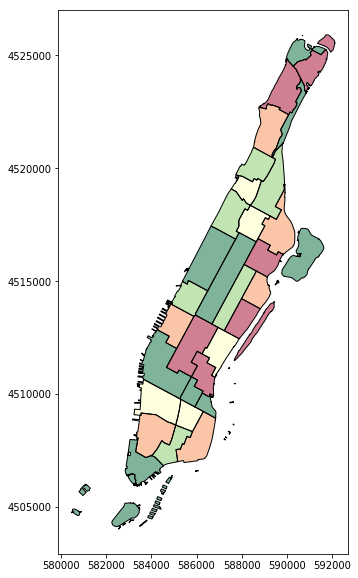

In [28]:
#health -- red = bad
kw = dict(column='tree_score', k=10, colormap='RdYlGn')
hp = villages.plot(scheme='QUANTILES', **kw)
fig = hp.get_figure()
fig.savefig('health-map.png')

In [29]:
#villages
villages.to_csv('villages_health-1.csv')

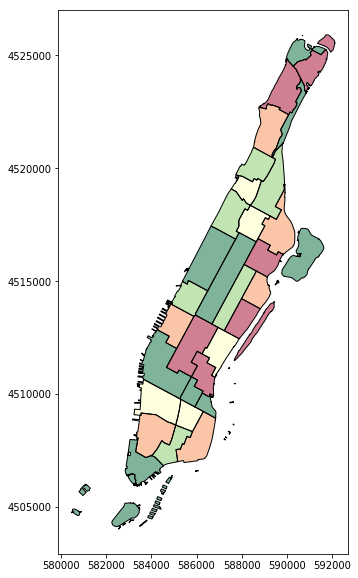

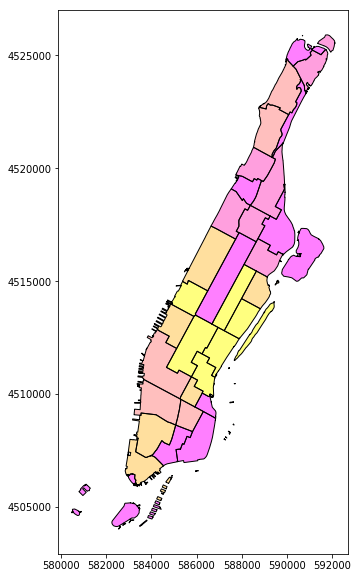

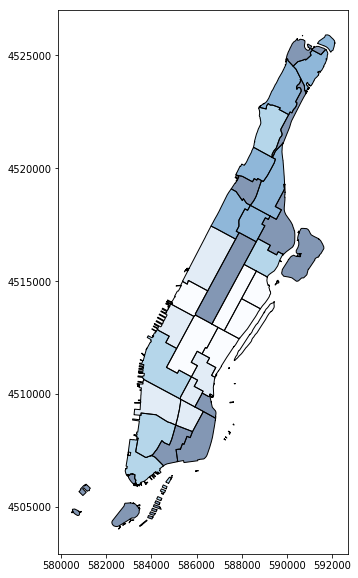

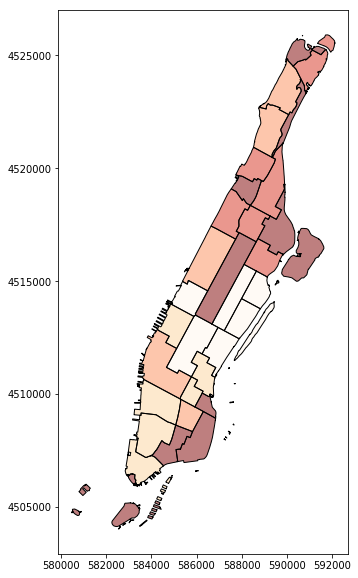

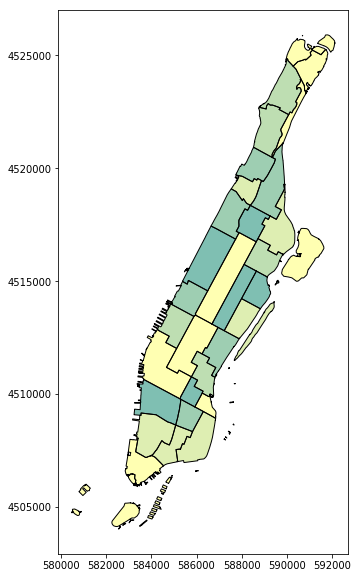

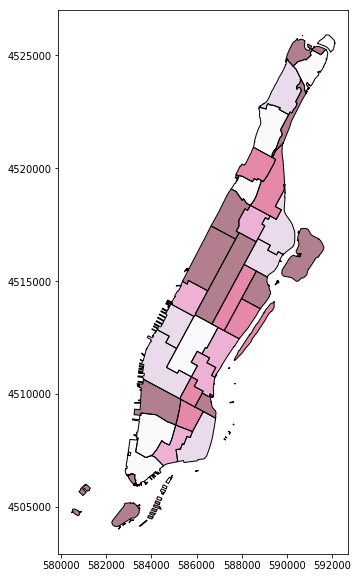

In [30]:
#health -- red = bad
kw = dict(column='tree_score', k=10, colormap='RdYlGn')
hp = villages.plot(scheme='QUANTILES', **kw)
fig = hp.get_figure()
fig.savefig('health-map.png')

#summershadows -- pink = more time
kw = dict(column='shadow_summer', k=10, colormap='spring')
ss = villages.plot(scheme='QUANTILES', **kw)
fig = ss.get_figure()
fig.savefig('summer-shadow-map.png')

#wintershadows -- darker blue = more time
kw = dict(column='shadow_winter', k=10, colormap='Blues_r')
ws = villages.plot(scheme='QUANTILES', **kw)
fig = ws.get_figure()
fig.savefig('winter-shadow-map.png')

#fallshadows -- darker orange = more time
kw = dict(column='shadow_fall', k=10, colormap='OrRd_r')
fs = villages.plot(scheme='QUANTILES', **kw)
fig = fs.get_figure()
fig.savefig('fall-shadow-map.png')

#density -- dark green = more dense
kw = dict(column='density', k=10, colormap='summer_r')
dens = villages.plot(scheme='QUANTILES', **kw)
fig = dens.get_figure()
fig.savefig('density-map.png')

#height -- dark purple = taller
kw = dict(column='height_mean', k=10, colormap='PuRd')
h = villages.plot(scheme='QUANTILES', **kw)
fig = h.get_figure()
fig.savefig('height-map.png')

### .. now, look at the average height of the trees .. 
* check Central Park again!